# Study 2: Upstream Extraction Benchmark (API vs LLM vs Embedding)

## Objective
Identify the best method for generating atomic {criterion_type, source_sentence} units.


In [ ]:
# ================================================================
# Cell 0 – Imports, paths, trial IDs, models
# ================================================================
import os
import json
from typing import Any, Dict, List

import requests
import pandas as pd

pd.set_option("display.max_colwidth", 200)

# --- Base paths ---
BASE_DIR  = "/Users/guoshuyan/Desktop/OpenAD"
RAW_DATA  = os.path.join(BASE_DIR, "Raw_data")         # v2 JSON
OUT_DIR   = os.path.join(BASE_DIR, "Study2_outputs")
GOLD_CSV  = os.path.join(BASE_DIR, "gold_atomic_criteria.csv")  # optional later

os.makedirs(OUT_DIR, exist_ok=True)

# --- Trial IDs for Study 2 upstream benchmark ---
# Import centralized trial list
import sys
sys.path.append('/Users/guoshuyan/Desktop/OpenAD')
from trial_ids_20 import TRIAL_IDS_STUDY2, TRIAL_IDS_20

# Use subset for faster testing, or all 20 for full evaluation
TRIAL_IDS = TRIAL_IDS_STUDY2  # Subset for quick testing
# TRIAL_IDS = TRIAL_IDS_20  # Uncomment to use all 20 trials

# Alternative: Define directly
# TRIAL_IDS = [
#     "NCT01767311",
#     "NCT02008357",
#     "NCT02477800",
#     # Add more as needed
# ]

# --- Canonical model names for routing ---
MODELS = [
    "gpt5o",    # OpenAI GPT-5-o (or GPT-4.x equivalent)
    "gemini",   # Gemini 1.5 Pro
    "deepseek", # DeepSeek chat
    "qwen",     # Qwen-Max (DashScope)
    "kimi",     # Kimi K2 Turbo Preview
]

print("BASE_DIR:", BASE_DIR)
print("RAW_DATA:", RAW_DATA)
print("OUT_DIR:", OUT_DIR)
print("TRIAL_IDS:", TRIAL_IDS)
print("MODELS:", MODELS)


BASE_DIR: /Users/guoshuyan/Desktop/OpenAD
RAW_DATA: /Users/guoshuyan/Desktop/OpenAD/Raw_data
OUT_DIR: /Users/guoshuyan/Desktop/OpenAD/Study2_outputs
TRIAL_IDS: ['NCT01767311', 'NCT02008357', 'NCT02477800']
MODELS: ['gpt5o', 'gemini', 'deepseek', 'qwen', 'kimi']


In [32]:
# ================================================================
# Cell 2 – JSON loading & eligibility extraction
# ================================================================
from typing import Any, Dict

def load_json(path: str) -> Dict[str, Any]:
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def extract_study_obj(data: Dict[str, Any]) -> Dict[str, Any]:
    """
    Robust Study extractor for:
      - v2 full response: {"studies": [ {...} ]}
      - your Raw_data JSON: already starts at Study level with "protocolSection"
      - legacy v1: {"FullStudiesResponse": {"FullStudies": [{"Study": {...}}]}}
    """
    if not data:
        return {}
    if "studies" in data and isinstance(data["studies"], list) and data["studies"]:
        return data["studies"][0]
    if "protocolSection" in data:
        return data
    if "FullStudiesResponse" in data:
        try:
            return data["FullStudiesResponse"]["FullStudies"][0]["Study"]
        except Exception:
            return {}
    return {}

def get_eligibility_text(study: Dict[str, Any]) -> str:
    """
    Extract EligibilityCriteria block if present.
    """
    if not study:
        return ""
    # v2 / your JSON style
    try:
        return study["protocolSection"]["eligibilityModule"]["eligibilityCriteria"] or ""
    except Exception:
        pass
    # v1 fallback
    try:
        return study["ProtocolSection"]["EligibilityModule"]["EligibilityCriteria"] or ""
    except Exception:
        return ""

def split_inclusion_exclusion(raw_text: str) -> Dict[str, str]:
    """
    Crude heuristic split into inclusion / exclusion sections.
    Good enough for upstream segmentation; gold will correct details.
    """
    text = raw_text.replace("\r\n", "\n")
    lower = text.lower()

    inc_idx = lower.find("inclusion criteria")
    exc_idx = lower.find("exclusion criteria")

    inclusion = ""
    exclusion = ""

    if inc_idx != -1:
        if exc_idx != -1:
            inclusion = text[inc_idx:exc_idx].strip()
            exclusion = text[exc_idx:].strip()
        else:
            inclusion = text[inc_idx:].strip()
    elif exc_idx != -1:
        exclusion = text[exc_idx:].strip()
    else:
        inclusion = text.strip()

    return {"inclusion": inclusion, "exclusion": exclusion}


In [33]:
# ================================================================
# Cell 3 – Prompt builder for atomic eligibility criteria
# ================================================================
import textwrap

def build_segmentation_prompt(trial_id: str, criterion_type: str, section_text: str) -> str:
    return textwrap.dedent(f"""
    You are an expert clinical trial information extraction system.

    Task: From the following eligibility section of trial {trial_id}, extract a list of
    atomic eligibility criteria of type "{criterion_type}".

    "Atomic" means:
      - Each criterion is a single logical condition.
      - Do NOT merge multiple logical conditions into one sentence.
      - Do NOT split a single logically unified sentence into tiny fragments.

    Output format:
      Return ONLY a valid JSON array, with NO extra text.
      Each element must be an object with fields:
        - "trial_id" (string)
        - "criterion_type" (string: "inclusion" or "exclusion")
        - "source_sentence" (string: the extracted sentence as it appears, with minimal edits)

      Example:
      [
        {{"trial_id": "NCT00000000", "criterion_type": "inclusion", "source_sentence": "Age 50 to 85 years."}},
        {{"trial_id": "NCT00000000", "criterion_type": "inclusion", "source_sentence": "MMSE score between 20 and 30 at screening."}}
      ]

    Important:
      - Preserve negations ("no history of stroke") and constraints.
      - Do not invent criteria; only use text actually present.
      - If the section is empty, return [].

    Here is the section text:

    \"\"\"{section_text}\"\"\"
    """)


In [44]:
# ================================================================
# Cell 5 – Parse LLM output JSON into a DataFrame
# ================================================================
def extract_json_array(text: str):
    """
    Extract a JSON array from potentially noisy model output.
    We look for the first '[' and last ']' and parse that.
    """
    text = text.strip()
    # Remove ``` fences if there
    if text.startswith("```"):
        # remove leading and trailing backticks crudely
        text = text.strip("`")
    start = text.find("[")
    end = text.rfind("]")
    if start == -1 or end == -1 or end <= start:
        raise ValueError("No JSON array found in model output.")
    json_str = text[start:end+1]
    return json.loads(json_str)

def llm_output_to_df(model: str, trial_id: str, criterion_type: str, raw_output: str) -> pd.DataFrame:
    arr = extract_json_array(raw_output)
    if not isinstance(arr, list):
        raise ValueError("Expected a JSON list from model.")

    rows = []
    for obj in arr:
        if not isinstance(obj, dict):
            continue
        t_id = obj.get("trial_id", trial_id)
        ctype = (obj.get("criterion_type", criterion_type) or "").lower()
        sent = (obj.get("source_sentence", "") or "").strip()
        if not sent:
            continue
        rows.append(
            {
                "model": model,
                "trial_id": t_id,
                "criterion_type": ctype,
                "source_sentence": sent,
            }
        )
    return pd.DataFrame(rows)


In [55]:
# ================================================================
# Cell 6 – Run upstream extraction for 3 trials × 5 LLMs
# ================================================================
all_extractions: List[pd.DataFrame] = []

for model in MODELS:
    print(f"=== {model} ===")
    for tid in TRIAL_IDS:
        json_path = os.path.join(RAW_DATA, f"{tid}.json")
        data = load_json(json_path)
        study = extract_study_obj(data)
        elig = get_eligibility_text(study)
        sections = split_inclusion_exclusion(elig)

        for ctype in ["inclusion", "exclusion"]:
            section_text = sections.get(ctype, "").strip()
            if not section_text:
                continue

            prompt = build_segmentation_prompt(tid, ctype, section_text)
            raw_output = call_model(model, prompt)
            if not raw_output:
                print(f"  ⚠️ {tid} / {ctype} → {model} returned no output.")
                continue
            try:
                df_out = llm_output_to_df(model, tid, ctype, raw_output)
                all_extractions.append(df_out)
                print(f"  {tid} / {ctype}: {len(df_out)} atomic rows")
            except Exception as e:
                print(f"  ⚠️ {tid} / {ctype} failed for {model}: {e}")

# Combine all results
if all_extractions:
    pred_df = pd.concat(all_extractions, ignore_index=True)
else:
    pred_df = pd.DataFrame(columns=["model", "trial_id", "criterion_type", "source_sentence"])

combined_path = os.path.join(OUT_DIR, "study2_upstream_all_models.csv")
pred_df.to_csv(combined_path, index=False)
print(f"\nCombined predictions saved to: {combined_path}")
print("Models present:", pred_df["model"].unique() if not pred_df.empty else "NONE")

# Save per-model CSV as well
for m in pred_df["model"].unique():
    m_df = pred_df[pred_df["model"] == m]
    out_path = os.path.join(OUT_DIR, f"study2_upstream_{m}.csv")
    m_df.to_csv(out_path, index=False)
    print(f"{m}: {len(m_df)} rows → {out_path}")


=== gpt5o ===
  NCT01767311 / inclusion: 27 atomic rows
  NCT01767311 / exclusion: 12 atomic rows
  NCT02008357 / inclusion: 5 atomic rows
  NCT02008357 / exclusion: 9 atomic rows
  NCT02477800 / inclusion: 7 atomic rows
  NCT02477800 / exclusion: 11 atomic rows
=== gemini ===
  NCT01767311 / inclusion: 22 atomic rows
  NCT01767311 / exclusion: 12 atomic rows
  NCT02008357 / inclusion: 5 atomic rows
  NCT02008357 / exclusion: 9 atomic rows
  NCT02477800 / inclusion: 8 atomic rows
  NCT02477800 / exclusion: 11 atomic rows
=== deepseek ===
  NCT01767311 / inclusion: 18 atomic rows
  NCT01767311 / exclusion: 12 atomic rows
  NCT02008357 / inclusion: 5 atomic rows
  NCT02008357 / exclusion: 9 atomic rows
  NCT02477800 / inclusion: 7 atomic rows
  NCT02477800 / exclusion: 11 atomic rows
=== qwen ===
  ⚠️ NCT01767311 / inclusion failed for qwen: Invalid \escape: line 19 column 218 (char 3134)
  NCT01767311 / exclusion: 16 atomic rows
  NCT02008357 / inclusion: 5 atomic rows
  NCT02008357 / e

Evaluation

In [75]:
# ================================================================
# Cell A – Load gold + all model predictions (CLEAN VERSION)
# ================================================================
import os
import pandas as pd
import re
import matplotlib.pyplot as plt

BASE_DIR  = "/Users/guoshuyan/Desktop/OpenAD"
OUT_DIR   = os.path.join(BASE_DIR, "Study2_outputs")
GOLD_CSV  = os.path.join(BASE_DIR, "gold_atomic_criteria.csv")

TRIAL_IDS = ["NCT01767311", "NCT02008357", "NCT02477800"]
MODELS = ["gpt5o", "gemini", "deepseek", "qwen", "kimi"]


# =========================================================
# Normalizer for both gold + preds
# =========================================================
def normalize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.replace("\ufeff", "", regex=False)
        .str.strip()
        .str.lower()
    )

    rename_map = {
        "trail_id": "trial_id",
        "study_id": "trial_id",
        "id": "trial_id",
        "nctid": "trial_id",
        "sentence": "source_sentence",
        "sentence_text": "source_sentence",
        "text": "source_sentence",
        "criteria_type": "criterion_type",
    }
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    return df


# =========================================================
# Load GOLD
# =========================================================
if not os.path.exists(GOLD_CSV):
    raise FileNotFoundError(f"Gold CSV missing at {GOLD_CSV}")

gold_df = pd.read_csv(GOLD_CSV, encoding="utf-8-sig")
gold_df = normalize_columns(gold_df)

required_cols = ["trial_id", "criterion_type", "source_sentence"]
for c in required_cols:
    if c not in gold_df.columns:
        raise KeyError(f"Gold CSV missing required column: {c}")

gold_df["trial_id"] = gold_df["trial_id"].astype(str).str.strip()
gold_df["criterion_type"] = gold_df["criterion_type"].astype(str).str.lower().str.strip()
gold_df["source_sentence"] = gold_df["source_sentence"].fillna("").astype(str).str.strip()

gold_df = gold_df[gold_df["trial_id"].isin(TRIAL_IDS)].reset_index(drop=True)

print("Gold rows:", len(gold_df))
display(gold_df.head())


# =========================================================
# Load predictions
# =========================================================
predictions = {}

for m in MODELS:
    fpath = os.path.join(OUT_DIR, f"study2_upstream_{m}.csv")
    if not os.path.exists(fpath):
        print(f"⚠ Missing: {fpath}")
        continue

    df = pd.read_csv(fpath, encoding="utf-8-sig")
    df = normalize_columns(df)

    # ensure required columns exist
    for c in required_cols:
        if c not in df.columns:
            raise KeyError(f"{m} prediction missing '{c}' column")

    df["trial_id"] = df["trial_id"].astype(str).str.strip()
    df["criterion_type"] = df["criterion_type"].astype(str).str.lower().str.strip()
    df["source_sentence"] = df["source_sentence"].fillna("").astype(str).str.strip()

    df = df[df["trial_id"].isin(TRIAL_IDS)].reset_index(drop=True)
    predictions[m] = df
    print(f"{m}: {len(df)} predicted atomic rows.")

Gold rows: 35


,trial_id,criterion_type,source_sentence
0,NCT02008357,inclusion,Has a Mini-Mental State Examination (MMSE) score at screening of 25 to 30
1,NCT02008357,inclusion,Has a global Clinical Dementia Rating (CDR) scale score at screening of 0
2,NCT02008357,inclusion,Has a Logical Memory II score at screening of 6 to 18
3,NCT02008357,inclusion,Has a florbetapir positron emission tomography (PET) scan that shows evidence of brain amyloid pathology at screening
4,NCT02008357,inclusion,"Has a study partner that is willing to participate as a source of information and has at least weekly contact with the participant (contact can be in-person, via telephone or electronic communicat..."


gpt5o: 71 predicted atomic rows.
gemini: 67 predicted atomic rows.
deepseek: 62 predicted atomic rows.
qwen: 48 predicted atomic rows.
kimi: 75 predicted atomic rows.


In [80]:
# ================================================================
# Cell 1 – Load gold + all model predictions
# ================================================================
import os
import pandas as pd

BASE_DIR  = "/Users/guoshuyan/Desktop/OpenAD"
OUT_DIR   = os.path.join(BASE_DIR, "Study2_outputs")
GOLD_CSV  = os.path.join(BASE_DIR, "gold_atomic_criteria.csv")

TRIAL_IDS = [
    "NCT01767311",
    "NCT02008357",
    "NCT02477800",
]

MODELS = ["gpt5o", "gemini", "deepseek", "qwen", "kimi"]

# --- Load gold ---
if not os.path.exists(GOLD_CSV):
    raise FileNotFoundError(
        f"Gold file not found at {GOLD_CSV}. "
        "Please create/edit gold_atomic_criteria.csv first."
    )

gold_df = pd.read_csv(GOLD_CSV)
required_cols = {"trial_id", "criterion_type", "source_sentence"}
if not required_cols.issubset(gold_df.columns):
    raise ValueError(f"Gold CSV must have columns: {required_cols}")

# normalize
gold_df["trial_id"] = gold_df["trial_id"].astype(str)
gold_df["criterion_type"] = gold_df["criterion_type"].str.lower().str.strip()
gold_df["source_sentence"] = gold_df["source_sentence"].fillna("").astype(str).str.strip()

# restrict to the 3 Study 2 trials
gold_df = gold_df[gold_df["trial_id"].isin(TRIAL_IDS)].reset_index(drop=True)

print("Gold rows for Study 2 (3 trials):", len(gold_df))
display(gold_df.head())

# --- Load all predictions for the 5 models ---
predictions = {}
for m in MODELS:
    pred_path = os.path.join(OUT_DIR, f"study2_upstream_{m}.csv")
    if not os.path.exists(pred_path):
        print(f"⚠️ Missing prediction file for {m}: {pred_path}")
        continue

    df = pd.read_csv(pred_path)
    df["trial_id"] = df["trial_id"].astype(str)
    df["criterion_type"] = df["criterion_type"].str.lower().str.strip()
    df["source_sentence"] = df["source_sentence"].fillna("").astype(str).str.strip()
    df = df[df["trial_id"].isin(TRIAL_IDS)].reset_index(drop=True)

    predictions[m] = df
    print(f"{m}: {len(df)} predicted atomic rows over 3 trials")


Gold rows for Study 2 (3 trials): 68


,trial_id,criterion_type,source_sentence
0,NCT01767311,inclusion,Subjects who meet the National Institute of Aging - Alzheimer's Association (NIA-AA) core clinical criteria for mild cognitive impairment due to Alzheimer's disease – intermediate likelihood.
1,NCT01767311,inclusion,Subjects who have a Clinical Dementia Rating (CDR) score of 0.5 and a Memory Box score of 0.5 or greater at Screening and Baseline.
2,NCT01767311,inclusion,"Subjects who report a history of subjective memory decline with gradual onset and slow progression over the last one year before Screening, which must be corroborated by an informant."
3,NCT01767311,inclusion,Subjects who meet the NIA-AA core clinical criteria for probable Alzheimer's disease dementia.
4,NCT01767311,inclusion,Subjects who have a CDR score of 0.5–1.0 and a Memory Box score of 0.5 or greater at Screening and Baseline.


gpt5o: 71 predicted atomic rows over 3 trials
gemini: 67 predicted atomic rows over 3 trials
deepseek: 62 predicted atomic rows over 3 trials
qwen: 48 predicted atomic rows over 3 trials
kimi: 75 predicted atomic rows over 3 trials


In [87]:
# ================================================================
# Cell 2 – Matching & metrics (Recall, Precision, F1, error typology)
# ================================================================
from difflib import SequenceMatcher

try:
    from rapidfuzz import fuzz
    HAS_RAPIDFUZZ = True
except ImportError:
    HAS_RAPIDFUZZ = False

def sentence_similarity(a: str, b: str) -> float:
    """Token-based similarity if rapidfuzz is available, else char similarity."""
    a = a or ""
    b = b or ""
    if HAS_RAPIDFUZZ:
        return fuzz.token_set_ratio(a, b) / 100.0
    return SequenceMatcher(None, a, b).ratio()

def match_model_to_gold(pred: pd.DataFrame, gold: pd.DataFrame,
                        sim_threshold: float = 0.8) -> dict:
    """
    Compute Study 2 metrics between predicted and gold atomic criteria:

    - Recall   = matched gold / total gold
    - Precision= matched preds / total preds
    - F1       = harmonic mean
    - Error typology:
        - missing_criteria (FN)
        - over_splitting_or_fp (FP / over-splitting)
        - under_splitting_or_fn (not matched)
        - inclusion_exclusion_inversion
    """
    g = gold.copy().reset_index(drop=True)
    p = pred.copy().reset_index(drop=True)

    g["matched"] = False
    p["matched"] = False

    matched_gold = 0
    missing_criteria = 0
    inversion_count = 0

    # Greedy matching: for each gold row, find best unmatched pred
    for g_idx, g_row in g.iterrows():
        best_sim = 0.0
        best_p_idx = None

        for p_idx, p_row in p.iterrows():
            if p_row["matched"]:
                continue
            if p_row["trial_id"] != g_row["trial_id"]:
                continue

            sim = sentence_similarity(g_row["source_sentence"], p_row["source_sentence"])

            same_type = (p_row["criterion_type"] == g_row["criterion_type"])

            # Prefer same-type, then similarity
            if same_type and sim > best_sim:
                best_sim = sim
                best_p_idx = p_idx
            elif not same_type and sim > best_sim and best_p_idx is None:
                # weaker candidate if no same-type candidate exists
                best_sim = sim
                best_p_idx = p_idx

        if best_p_idx is not None and best_sim >= sim_threshold:
            g.at[g_idx, "matched"] = True
            p.at[best_p_idx, "matched"] = True
            matched_gold += 1
            if p.at[best_p_idx, "criterion_type"] != g_row["criterion_type"]:
                inversion_count += 1
        else:
            missing_criteria += 1

    total_gold = len(g)
    total_pred = len(p)

    recall = matched_gold / total_gold if total_gold > 0 else 0.0
    precision = matched_gold / total_pred if total_pred > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    over_fp = max(total_pred - matched_gold, 0)
    under_fn = missing_criteria

    return {
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "n_gold": total_gold,
        "n_pred": total_pred,
        "missing_criteria": missing_criteria,
        "over_splitting_or_fp": over_fp,
        "under_splitting_or_fn": under_fn,
        "inclusion_exclusion_inversion": inversion_count,
    }


In [88]:
# ================================================================
# Cell 3 – Evaluate all models & save metrics CSV
# ================================================================
results = []

for m in MODELS:
    if m not in predictions:
        print(f"⚠️ No predictions for model {m}, skipping.")
        continue

    m_pred = predictions[m]
    metrics = match_model_to_gold(m_pred, gold_df, sim_threshold=0.8)

    row = {"model": m}
    row.update(metrics)
    results.append(row)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("f1", ascending=False).reset_index(drop=True)

print("Study 2 — Upstream Extraction Benchmark (3 trials):")
display(
    results_df.assign(
        recall=lambda x: x["recall"].round(3),
        precision=lambda x: x["precision"].round(3),
        f1=lambda x: x["f1"].round(3),
    )
)

# --- Save metrics table as CSV ---
metrics_csv = os.path.join(OUT_DIR, "study2_upstream_eval_metrics.csv")
results_df.to_csv(metrics_csv, index=False)
print(f"\n✅ Metrics saved to: {metrics_csv}")


Study 2 — Upstream Extraction Benchmark (3 trials):


,model,recall,precision,f1,n_gold,n_pred,missing_criteria,over_splitting_or_fp,under_splitting_or_fn,inclusion_exclusion_inversion
0,kimi,0.897,0.813,0.853,68,75,7,14,7,0
1,gemini,0.838,0.851,0.844,68,67,11,10,11,0
2,gpt5o,0.853,0.817,0.835,68,71,10,13,10,0
3,deepseek,0.794,0.871,0.831,68,62,14,8,14,0
4,qwen,0.544,0.771,0.638,68,48,31,11,31,0



✅ Metrics saved to: /Users/guoshuyan/Desktop/OpenAD/Study2_outputs/study2_upstream_eval_metrics.csv


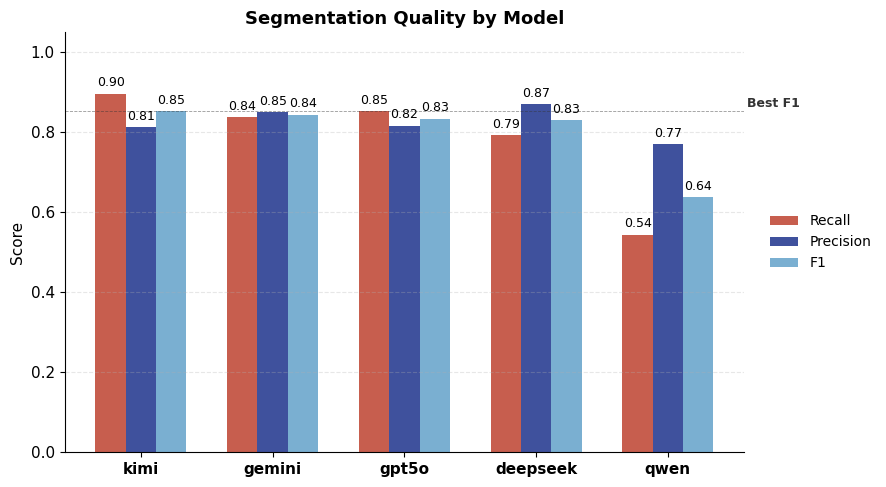

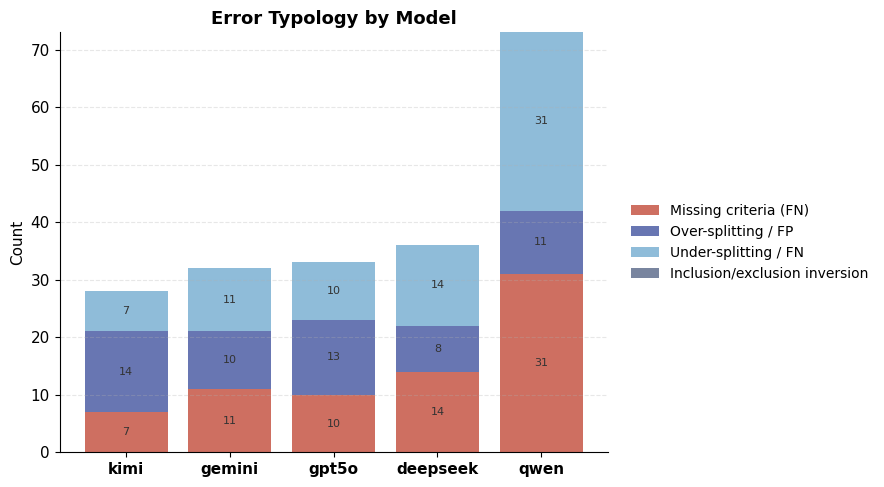

In [89]:
# ================================================================
# Cell 5 – Publication-quality plots (Recall/Precision/F1 + errors)
# ================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

df = results_df.copy()
models = df["model"].tolist()
x = np.arange(len(models))

card_palette = {
    "recall": "#C55645",   # warm red
    "precision": "#354898", # deep blue
    "f1": "#73ABCF",        # teal blue
}

def blend_with_white(hex_color: str, strength: float = 0.5) -> str:
    """Blend the input color with white to create lighter tints."""
    rgb = np.array(mcolors.to_rgb(hex_color))
    white = np.ones(3)
    blended = white * (1 - strength) + rgb * strength
    return mcolors.to_hex(np.clip(blended, 0, 1))

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
})

# ---------- Figure 1: Recall / Precision / F1 by model ----------
fig, ax = plt.subplots(figsize=(9, 5))
fig.patch.set_facecolor("none")
ax.set_facecolor("none")
width = 0.23

for idx, metric in enumerate(["recall", "precision", "f1"]):
    offset = (idx - 1) * width
    bars = ax.bar(
        x + offset,
        df[metric],
        width,
        label=metric.title(),
        color=card_palette[metric],
        edgecolor="none",
        alpha=0.95,
    )
    ax.bar_label(bars, fmt="{:.2f}", padding=3, fontsize=9)

best_idx = df["f1"].idxmax()
ax.axhline(df.loc[best_idx, "f1"], color="#333333", linewidth=0.6, linestyle="--", alpha=0.5)
ax.text(
    len(models) - 0.4,
    df.loc[best_idx, "f1"] + 0.01,
    "Best F1",
    color="#333333",
    fontsize=9,
    fontweight="bold",
)

ax.set_xticks(x)
ax.set_xticklabels(models, fontweight="bold")
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Segmentation Quality by Model", fontweight="bold")
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

# ---------- Figure 2: Error typology stacked bars ----------
fig, ax = plt.subplots(figsize=(9, 5))
fig.patch.set_facecolor("none")
ax.set_facecolor("none")

error_layers = [
    ("missing_criteria", "Missing criteria (FN)", blend_with_white(card_palette["recall"], 0.85)),
    ("over_splitting_or_fp", "Over-splitting / FP", blend_with_white(card_palette["precision"], 0.75)),
    ("under_splitting_or_fn", "Under-splitting / FN", blend_with_white(card_palette["f1"], 0.8)),
    ("inclusion_exclusion_inversion", "Inclusion/exclusion inversion", blend_with_white("#1f335f", 0.6)),
]

bottom = np.zeros(len(models))
for metric, label, color in error_layers:
    values = df[metric].values
    bars = ax.bar(x, values, bottom=bottom, label=label, color=color, edgecolor="none")
    ax.bar_label(bars, labels=[f"{int(v)}" if v else "" for v in values], label_type="center", fontsize=8, color="#333333")
    bottom += values

ax.set_xticks(x)
ax.set_xticklabels(models, fontweight="bold")
ax.set_ylabel("Count")
ax.set_title("Error Typology by Model", fontweight="bold")
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()
